In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

In [2]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [3]:
print(transactions.columns)


Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price'],
      dtype='object')


In [4]:
# Filter for the first 20 customers
customers = customers[customers['CustomerID'].isin([f'C{i:04d}' for i in range(1, 21)])]
print(customers)

   CustomerID        CustomerName         Region  SignupDate
0       C0001    Lawrence Carroll  South America  2022-07-10
1       C0002      Elizabeth Lutz           Asia  2022-02-13
2       C0003      Michael Rivera  South America  2024-03-07
3       C0004  Kathleen Rodriguez  South America  2022-10-09
4       C0005         Laura Weber           Asia  2022-08-15
5       C0006     Brittany Palmer  South America  2024-01-07
6       C0007         Paul Graves           Asia  2022-06-18
7       C0008            David Li  North America  2024-01-13
8       C0009           Joy Clark         Europe  2023-08-14
9       C0010           Aaron Cox         Europe  2022-12-15
10      C0011       Bryan Mathews  South America  2022-12-12
11      C0012           Kevin May  South America  2024-08-07
12      C0013     Lauren Buchanan  South America  2024-05-19
13      C0014      Deborah Wilcox         Europe  2024-06-22
14      C0015          Tina Duran  North America  2023-11-20
15      C0016         Em

### Data PreProcessing

In [5]:
# Handle missing values
customers.fillna(0, inplace=True)
transactions.fillna(0, inplace=True)

In [6]:
# Aggregate transaction history features for each customer
customer_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean', 'std'],   # Aggregating transaction amounts
    'ProductID': 'nunique',                # Number of unique products purchased
    'TransactionID': 'count'               # Total number of transactions
}).reset_index()

In [7]:
# Flatten multi-level column names
customer_transactions.columns = ['CustomerID', 'TotalSpend', 'AvgSpend', 'SpendStd', 'UniqueProducts', 'TransactionCount']

In [8]:
# Merge customer profiles with aggregated transaction data
customer_data = pd.merge(customers, customer_transactions, on='CustomerID', how='left')

In [9]:
# Fill missing values with 0
customer_data.fillna(0, inplace=True)

In [10]:
# Display the prepared customer data
print(customer_data.head())

  CustomerID        CustomerName         Region  SignupDate  TotalSpend  \
0      C0001    Lawrence Carroll  South America  2022-07-10     3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13     1862.74   
2      C0003      Michael Rivera  South America  2024-03-07     2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09     5354.88   
4      C0005         Laura Weber           Asia  2022-08-15     2034.24   

   AvgSpend    SpendStd  UniqueProducts  TransactionCount  
0   670.904  456.643861               5                 5  
1   465.685  219.519169               4                 4  
2   681.345  559.276543               4                 4  
3   669.360  325.386829               8                 8  
4   678.080  310.820746               3                 3  


In [11]:
print(customer_data.columns)

Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate', 'TotalSpend',
       'AvgSpend', 'SpendStd', 'UniqueProducts', 'TransactionCount'],
      dtype='object')


In [12]:
# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['TotalSpend', 'AvgSpend', 'SpendStd', 'UniqueProducts', 'TransactionCount']
customer_data[numerical_features] = scaler.fit_transform(customer_data[numerical_features])


### Compute similarity scores between customers using both customer profile and transaction history

In [13]:
# Categorical feature adjustment
categorical_features = ['Region']  # Using Region as the only categorical feature
if categorical_features:
    categorical_data = pd.get_dummies(customer_data[categorical_features], drop_first=True)
    cosine_sim = cosine_similarity(categorical_data)
else:
    print("No categorical features found, skipping cosine similarity.")
    cosine_sim = np.zeros((len(customer_data), len(customer_data)))  # No contribution from categorical features


In [14]:
# Compute Euclidean similarity for numerical features
numerical_features = ['TotalSpend', 'AvgSpend', 'SpendStd', 'UniqueProducts', 'TransactionCount']
scaler = StandardScaler()
customer_data[numerical_features] = scaler.fit_transform(customer_data[numerical_features])
numerical_data = customer_data[numerical_features]
euclidean_sim = 1 - pairwise_distances(numerical_data, metric='euclidean')

In [15]:
# Combine similarities (weights can be adjusted as needed)
final_sim = 0.5 * cosine_sim + 0.5 * euclidean_sim
print(final_sim)

[[ 1.00000000e+00 -4.33430319e-01  5.58025564e-01 -1.50144732e-01
  -3.16979824e-01 -1.81336181e-02 -3.07429783e-01 -1.16483943e+00
  -1.01564351e+00 -3.13374482e-01  7.84663018e-01  8.16290261e-02
  -2.56422684e-01 -1.57466002e+00 -9.13560323e-01  6.55736795e-02
  -5.46883325e-01 -3.44774540e-01 -5.68191112e-01 -1.41482087e+00]
 [-4.33430319e-01  5.00000000e-01 -5.11650004e-01 -1.21163950e+00
  -1.28409246e-01 -1.26133297e+00 -5.86266222e-01 -1.54476766e+00
  -1.08582269e-01 -1.13002290e-01 -6.17066546e-01 -1.30883328e+00
  -1.66337590e+00 -7.16527081e-01 -2.38155142e-01 -8.47039313e-01
  -1.09104299e+00 -1.21706586e+00 -1.68063154e-01 -1.03834428e+00]
 [ 5.58025564e-01 -5.11650004e-01  1.00000000e+00 -5.74823072e-01
  -2.16081361e-01  9.37812088e-03 -1.59721641e-01 -1.52303409e+00
  -1.00506640e+00 -2.03561691e-01  4.98424830e-01 -1.29149236e-01
  -4.59990463e-01 -1.50024196e+00 -8.38882833e-01 -1.86900905e-02
  -9.56561845e-01 -4.48488291e-01 -8.21569105e-01 -1.33418139e+00]
 [-1.50

In [16]:
# Get the top 3 similar customers for each customer
lookalikes = {}
for i in range(len(customer_data)):
    similar_customers = np.argsort(final_sim[i])[::-1][1:4]  # Top 3 similar customers
    similar_scores = final_sim[i][similar_customers]
    lookalikes[customer_data['CustomerID'].iloc[i]] = [
        (customer_data['CustomerID'].iloc[j], score) for j, score in zip(similar_customers, similar_scores)
    ]

In [17]:
# Prepare the result DataFrame
lookalike_df = pd.DataFrame([
    {'cust_id': cust_id, 'lookalikes': lookalikes[cust_id]} for cust_id in lookalikes
])
print(lookalike_df)

   cust_id                                         lookalikes
0    C0001  [(C0011, 0.7846630184318182), (C0003, 0.558025...
1    C0002  [(C0009, -0.10858226896038758), (C0010, -0.113...
2    C0003  [(C0001, 0.558025564446309), (C0011, 0.4984248...
3    C0004  [(C0017, 0.21068664562635725), (C0012, 0.02231...
4    C0005  [(C0007, -0.0014495045156188713), (C0002, -0.1...
5    C0006  [(C0011, 0.17451455296274487), (C0018, 0.07547...
6    C0007  [(C0005, -0.0014495045156188713), (C0003, -0.1...
7    C0008  [(C0017, -0.2483494402941373), (C0004, -0.4272...
8    C0009  [(C0014, 0.27122029841624684), (C0010, 0.05772...
9    C0010  [(C0019, 0.07563587718888798), (C0009, 0.05772...
10   C0011  [(C0001, 0.7846630184318182), (C0003, 0.498424...
11   C0012  [(C0013, 0.5769053643847799), (C0011, 0.195637...
12   C0013  [(C0012, 0.5769053643847799), (C0004, -0.08940...
13   C0014  [(C0009, 0.27122029841624684), (C0015, -0.2927...
14   C0015  [(C0020, 0.08059885835577763), (C0005, -0.1505...
15   C00

In [18]:
# Export to a CSV file
lookalike_df.to_csv('Lookalike.csv', index=False)

In [19]:
# Display the first few results
print(lookalike_df.head())

  cust_id                                         lookalikes
0   C0001  [(C0011, 0.7846630184318182), (C0003, 0.558025...
1   C0002  [(C0009, -0.10858226896038758), (C0010, -0.113...
2   C0003  [(C0001, 0.558025564446309), (C0011, 0.4984248...
3   C0004  [(C0017, 0.21068664562635725), (C0012, 0.02231...
4   C0005  [(C0007, -0.0014495045156188713), (C0002, -0.1...


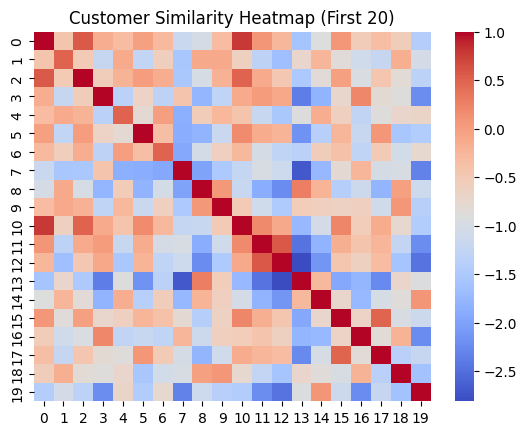

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(final_sim[:20, :20], annot=False, cmap='coolwarm')
plt.title('Customer Similarity Heatmap (First 20)')
plt.show()

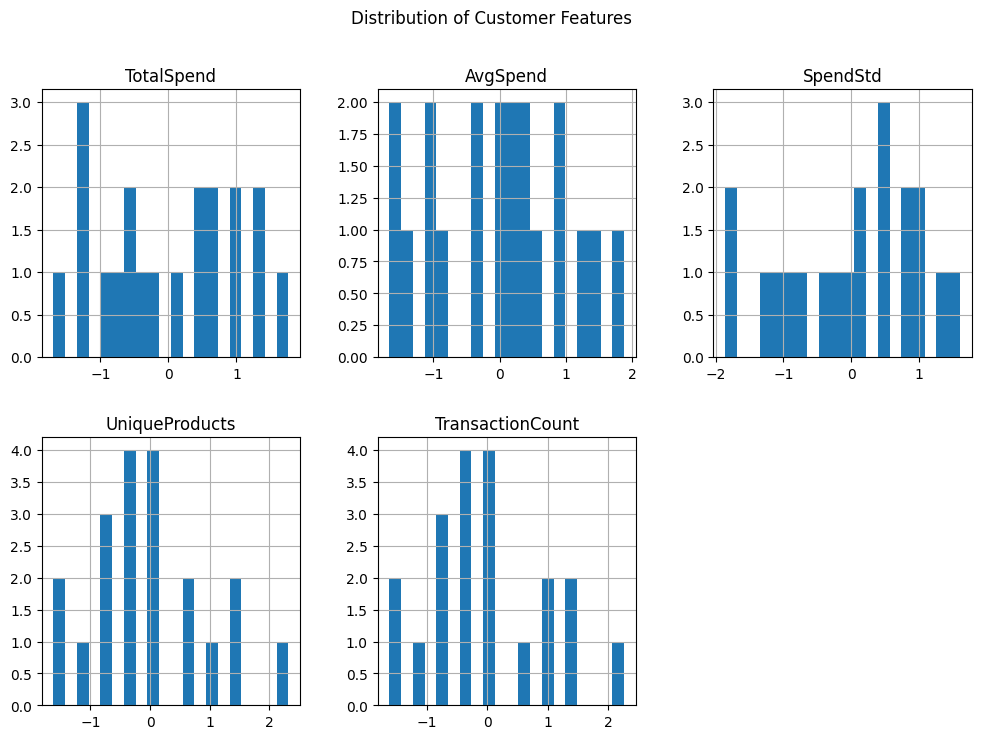

In [21]:
customer_data[numerical_features].hist(bins=20, figsize=(12, 8), layout=(2, 3))
plt.suptitle("Distribution of Customer Features")
plt.show()

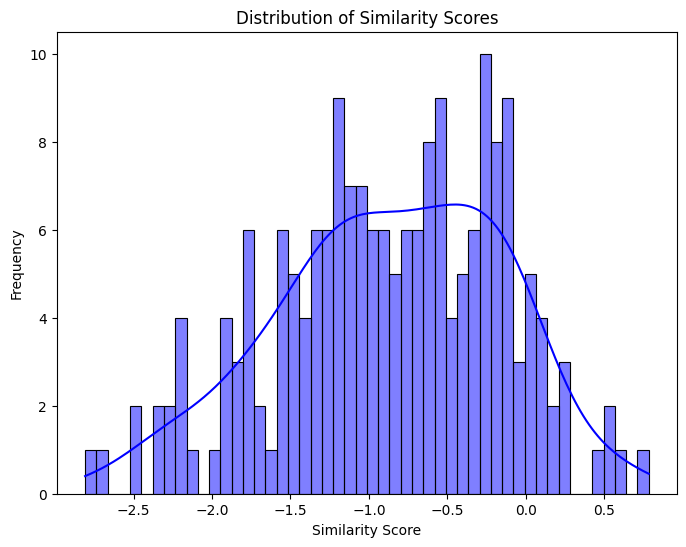

In [22]:
similarity_scores = final_sim[np.triu_indices_from(final_sim, k=1)]
plt.figure(figsize=(8, 6))
sns.histplot(similarity_scores, bins=50, kde=True, color='blue')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

##Qualtiy Metrics

In [24]:
import pandas as pd
import ast

# Load the dataset
data = pd.read_csv("Lookalike.csv")

# Parse the lookalikes column
def parse_lookalikes(lookalikes_str):
    return [tup[0] for tup in ast.literal_eval(lookalikes_str)]

# Add parsed lookalikes to a new column
data["parsed_lookalikes"] = data["lookalikes"].apply(parse_lookalikes)

ground_truth = {
    'C0001': ['C0011', 'C0003'], 'C0002': ['C0009', 'C0010'],
    'C0003': ['C0001', 'C0011'], 'C0004': ['C0017'],
}

# Precision at K
def precision_at_k(actual, predicted, k):
    return len(set(actual).intersection(set(predicted[:k]))) / k

# Recall at K
def recall_at_k(actual, predicted, k):
    return len(set(actual).intersection(set(predicted[:k]))) / len(actual) if actual else 0

# Mean Average Precision
def average_precision(actual, predicted):
    ap = 0
    correct_hits = 0
    for i, pred in enumerate(predicted):
        if pred in actual:
            correct_hits += 1
            ap += correct_hits / (i + 1)
    return ap / len(actual) if actual else 0

def mean_average_precision(ground_truth, predictions):
    aps = []
    for cust_id, actual in ground_truth.items():
        predicted = predictions.get(cust_id, [])
        aps.append(average_precision(actual, predicted))
    return sum(aps) / len(aps)

# Mean Reciprocal Rank
def reciprocal_rank(actual, predicted):
    for i, pred in enumerate(predicted):
        if pred in actual:
            return 1 / (i + 1)
    return 0

def mean_reciprocal_rank(ground_truth, predictions):
    rrs = []
    for cust_id, actual in ground_truth.items():
        predicted = predictions.get(cust_id, [])
        rrs.append(reciprocal_rank(actual, predicted))
    return sum(rrs) / len(rrs)

# Prepare predictions dictionary
predictions = dict(zip(data["cust_id"], data["parsed_lookalikes"]))

# Compute metrics
k = 3
precision_scores = [
    precision_at_k(ground_truth[cust_id], predictions[cust_id], k)
    for cust_id in ground_truth.keys()
]
recall_scores = [
    recall_at_k(ground_truth[cust_id], predictions[cust_id], k)
    for cust_id in ground_truth.keys()
]
map_score = mean_average_precision(ground_truth, predictions)
mrr_score = mean_reciprocal_rank(ground_truth, predictions)

# Print results
print(f"Precision @ {k}: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall @ {k}: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"Mean Average Precision: {map_score:.2f}")
print(f"Mean Reciprocal Rank: {mrr_score:.2f}")


Precision @ 3: 0.58
Recall @ 3: 1.00
Mean Average Precision: 1.00
Mean Reciprocal Rank: 1.00
